#                                     **Person of Interest Identifier**
This project is based on the [Enron scandal](https://en.wikipedia.org/wiki/Enron_scandal) of 2001, the data used here is the 
email and financial data of enron which was made public and can be found [here](https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz).
Here we identify people from the numerous enron employees which can be considered
as 'person of interest (poi)' i.e. who may have a hand in the scandal. The data has
handpicked people classified as poi which were convicted in reality. We use a supervised
learning approach to build our poi identifier. 

#### We begin by first importing the required packages. Here we mainly work with the scikit-learn package. 

In [1]:
import os
import sys
import pickle
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data,test_classifier
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

C:\Users\abhis\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Next we load our dataset.

In [2]:
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
my_dataset = data_dict

#### Initially we start with all the features in our data however these may contain noise and give a poor accuracy which will be optimized later. Further we extract the features and labels from this data for analysis. Finally we split these in training and testing data for our model.

In [3]:
features_list = ['poi','salary', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 
                 'exercised_stock_options', 'other', 'long_term_incentive', 
                 'restricted_stock', 'director_fees'] 

data = featureFormat(my_dataset, features_list, sort_keys = True)
print(data.shape)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

(145, 15)


#### To get an initial look at our validation figures we use the simple Naive Bayes classifier without any preprocessing.  We use a test_classifier function which evaluates and displays evaluation metrics.

In [4]:
clf = GaussianNB()
clf.fit(features_train,labels_train)
test_classifier(clf,data_dict,features_list)

GaussianNB(priors=None)
	Accuracy: 0.37753	Precision: 0.15641	Recall: 0.83500	F1: 0.26347	F2: 0.44707
	Total predictions: 15000	True positives: 1670	False positives: 9007	False negatives:  330	True negatives: 3993



#### As we can see we get a fairly low accuracy and recall score owing to the many features contributing as noise. Our first step towards improving these would be using Principal Component Analysis in which the components with maximum variance can be selected while others can be dropped.

In [5]:
num = 12 #This can be tuned to select different number of principal components
print(data.shape)
pca = PCA(n_components = num)
pca.fit(data)
dat = pca.transform(data)
print(dat.shape)

(145, 15)
(145, 12)


#### To further augment our selection we use feature selection. Here we use SelectKBest which selects the 'K' best features which explain the data.

In [6]:
import warnings 
warnings.filterwarnings('ignore') #so that warnings aren't printed

labels, features = targetFeatureSplit(dat)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

selector = SelectKBest(k=7) #To limit the number of features to seven (i.e. approximately half)
features_train = selector.fit_transform(features_train,labels_train)

mask = selector.get_support() 
new_features = [] 
#Here we printout our K best features
for bool, feature in zip(mask, features_list):
    if bool:
        new_features.append(feature)
print(new_features)

['loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options']


#### Other reasons for poor performance can be Outliers present in the data. This can be investigated by using visualization of our data.

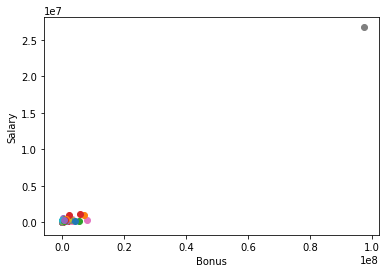

In [7]:
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
features_list = ['bonus','salary'] #Here we choose bonus & salary for visualization
data = featureFormat(data_dict,features_list)

for point in data:
    bonus = point[0]
    salary = point[1]
    plt.scatter(bonus,salary)
plt.xlabel('Bonus')
plt.ylabel('Salary')
plt.show()

#### We see the presence of a clear outlier in the data which has been hampering our results. We remove this from our original data and proceed with our analysis.

In [8]:
#To detect the outlier:
for i in data_dict:
    if (data_dict[i]['salary'] != "NaN") & (data_dict[i]['bonus'] != "NaN"):    
        if (data_dict[i]['salary'] >= 5000000) & (data_dict[i]['bonus'] >= 5000000):
            print("Outlier present is ",i)


Outlier present is  TOTAL


#### The outlier was actually the total row with total figures for all the enron employees. We now remove this for further analysis.  

In [9]:
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
data_dict.pop('TOTAL') #Outlier removal
my_dataset = data_dict
features_list = ['poi','loan_advances', 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options'] #New feature list

data = featureFormat(my_dataset, features_list, sort_keys = True)

#### The next classifier we intend to try is SVM. However, SVMs in general are affected by different ranges of the features and may result in output being dominated by a single feature. To overcome this issue we perform feature scaling, in which we first scale our features to an uniform scale of [0,1].

In [10]:
print('Before scaling = ',data[0,3])
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)
print('After scaling = ',scaled_data[0,3]) #Example showing feature scaling effect
labels, features = targetFeatureSplit(scaled_data)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

Before scaling =  -126027.0
After scaling =  0.09634567351381695


#### Now we build our SVM classifier and train it on our data.

In [11]:
clf = SVC()
clf.fit(features_train,labels_train)
test_classifier(clf,data_dict,features_list)

Got a divide by zero when trying out: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Precision or recall may be undefined due to a lack of true positive predicitons.


#### The result from the SVM classifier show that it doesn't perform well here as the number of true positives is very less. 

#### Next we try out the Random Forest algorithm with a different approach. Here we use GridSearch technique to find parameters which yield the best performance for our classifier.

In [12]:
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

rfc = RandomForestClassifier()
parameters = {'n_estimators':[10,50,100], 'max_features':('auto','log2')}
clf = GridSearchCV(rfc,parameters)
clf.fit(features_train,labels_train)
print(clf.best_params_)

{'max_features': 'log2', 'n_estimators': 100}


#### The above parameters are tested seperately below as test_classifier doesn't work well with GridSearchCV. 

In [13]:
clf = RandomForestClassifier(n_estimators=50,max_features='log2')
clf.fit(features_train,labels_train)
test_classifier(clf,data_dict,features_list)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.87021	Precision: 0.60292	Recall: 0.26800	F1: 0.37106	F2: 0.30150
	Total predictions: 14000	True positives:  536	False positives:  353	False negatives: 1464	True negatives: 11647



#### The result shows that this classifier performs fairly well, which can be clearly seen from the above scores. A huge reason for this is here we perform parameter tunning by testing different parameters and selecting the best ones. Changing parameters changes the performance of the classifier and can have impactful effects on its performance.
#### Speaking about the evaluation metrics, creating a classifier has no meaning until its performace is tested on data other than the data on which it was trained. This is called as validation, the train_test_split we have been performing, splits the data for training and testing for this purpose.
#### We obviously cannot rely on accuracy as a sole measure as it can be doctored easily by skewness present in our data. Hence we use a variety of metrics with accuracy to evaluate our classifier. The precision shows how well the classifier predicts a person of interest i.e. how well the classifer identifies a person as a poi and it is correct. On the other hand recall shows the fraction of total true cases, i.e. the probability of the classifier detecting a poi provided it is actually a poi.

#### Finally, another approach that is often used is creating new features out of the existing features that may help contribute towards the classification. Looking at our features, here we design a new feature called 'savings' which will be the net amout with a person including their salary and bonus and after excluding their expenses, this residual amount with a person can help in identifying their financial status which in this sense could mean their involvement in the fraud.

In [14]:
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
#New feature 'savings' created as follows
for key,i in data_dict.items():
    if i['salary']=='NaN':
        i['salary']=0
    if i['bonus']=='NaN':
        i['bonus']=0
    if i['expenses']=='NaN':
        i['expenses']=0
    i['savings'] = i['salary']+i['bonus']-i['expenses']
data_dict.pop('TOTAL') #Outlier removal
my_dataset = data_dict
#Our feature list this time will contain our new feature which will replace the two features it utilized 
features_list = ['poi','loan_advances', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'savings', 
                 'exercised_stock_options'] 
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

#### We next validate this new feature with our classifier and observe minor improvemets in accuracy. 
#### However when using our new feature list with the earlier Naive Bayes classifier, improvements in classification are clearly visible.

In [15]:
clf = RandomForestClassifier(n_estimators=50,max_features='log2')
clf.fit(features_train,labels_train)
test_classifier(clf,data_dict,features_list)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.87280	Precision: 0.54684	Recall: 0.26850	F1: 0.36016	F2: 0.29893
	Total predictions: 15000	True positives:  537	False positives:  445	False negatives: 1463	True negatives: 12555



In [16]:
clf = GaussianNB()
clf.fit(features_train,labels_train)
test_classifier(clf,data_dict,features_list)

GaussianNB(priors=None)
	Accuracy: 0.77387	Precision: 0.28236	Recall: 0.45150	F1: 0.34744	F2: 0.40320
	Total predictions: 15000	True positives:  903	False positives: 2295	False negatives: 1097	True negatives: 10705



#### Thus we have performed analysis on the Enron dataset classifying the employees as person of interests. Another approach which can be utilized for the same is performing text learning on the text data i.e. Enron email data.